In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import re
import pickle
import gc
import nltk
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from transformers import *
import tokenizers
import matplotlib.pyplot as plt
print('TF version',tf.__version__)

TF version 2.0.0


In [2]:
data = pd.read_csv("./data/train.csv")
testdata = pd.read_csv("./data/test.csv")
data.dropna(how="any", inplace=True)

In [3]:
def cleaner(sent):
    #Two tokens (WEBSITE, VULGAR) are created and punctuation is spaced out
    sent = " ".join(np.vectorize(lambda s:"WEBSITE" if "http" in s else s)(np.array(sent.split())))
    sent = re.sub("[!.?:;,`]", " ", sent)
    return re.sub(re.compile('(?:\*){2,}'),"VULGAR",sent).lower()
for col in ['text','selected_text']:
    data[col] = data[col].apply(lambda s: cleaner(s))
testdata['text'] = testdata['text'].apply(lambda s: cleaner(s))
data = data.loc[data.text.apply(lambda s: len(s))!=1]

In [4]:
PATH = './tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [5]:
def validitycheck(s):
    target = s.selected_text.split()
    source = s.text.split()
    for i in range(len(source)):
        if (source[i]==target[0]) and (source[i:i+len(target)]==target): return True
    return False
data = data.loc[data.apply(validitycheck, axis=1)].reset_index(drop=True)

<h2> N-Gram Level Subtext Model </h2>

We continue with the observations established in ATTEMPT 2 regarding the similarity between "text" and "selected_text" for neutral sentiments which makes it favorable to merely predict the entire text (at 0.92 accuracy). For positive and negative labels, we attempt classifier and regressor designs to predict subtexts, or predict Jaccardian similarity with subtexts.

<b> STEP 1: Classifier </b>

In [6]:
def X(text):
    ngrams, text = [], text.split()
    for i in range(len(text)):
        for j in range(i, len(text)):
            ngrams.append(" ".join(text[i:j+1]))
    return np.array(ngrams)
def Y(ngrams, selected_text):
    return np.vectorize(lambda s: int(s==selected_text))(np.array(ngrams))

In [7]:
length = data.loc[data.sentiment=="positive", "text"].apply(lambda s: np.sum(np.arange(len(s.split())+1)))
trainX = np.zeros(length.sum(), dtype="<U150")
trainY = np.zeros(length.sum(), dtype=np.float64)
i=0
for index, content in data.loc[data.sentiment=="positive"].iterrows():
    ngrams = X(content.text)
    trainX[i:i+len(ngrams)] = ngrams
    trainY[i:i+len(ngrams)] =  Y(ngrams, content.selected_text)
    i+=len(ngrams)

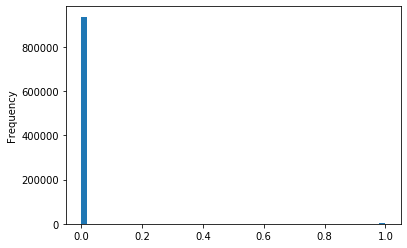

In [8]:
pd.Series(trainY).plot(kind="hist", bins=50)
plt.show()

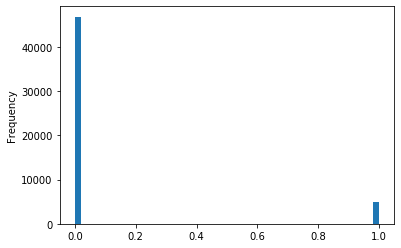

In [9]:
#Undersampling - Create a 5% Sampling Ratio
majority, minority = np.where(trainY==0)[0], np.where(trainY==1)[0]
kp = np.random.choice(majority, int(0.05*len(majority)), replace=False)
trainX = trainX[np.sort(np.append(minority, kp))]
trainY = trainY[np.sort(np.append(minority, kp))]
pd.Series(trainY).plot(kind="hist", bins=50)
plt.show()

In [10]:
#Positive Labels
MAX_LEN = 100
input_ids = np.ones((len(trainX),MAX_LEN),dtype='int32')
attention_mask = np.zeros((len(trainX),MAX_LEN),dtype='int32')
token_type_ids = np.zeros((len(trainX),MAX_LEN),dtype='int32')

for k in range(len(trainX)):
    text1 = " "+" ".join(trainX[k].split())
    enc = tokenizer.encode(text1)
    s_tok = sentiment_id["positive"]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1

In [12]:
#Word-Level BERT LSTM ANN
def dense_mdl(nunits=100, recdrp=0.05, l2reg=0.05, drp=0.05):
    input_ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    x1 = tf.keras.layers.LSTM(nunits, recdrp=recdrp, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                              bias_regularizer=tf.keras.regularizers.l2(l2reg), return_sequences=False)(x[0])
    x1 = tf.keras.layers.Dropout(drp)(x1)
    final = tf.keras.layers.Dense(1, activation="sigmoid")(x1)
    model = tf.keras.models.Model([input_ids, attention_mask, token_type_ids], final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss="binary_crossentropy")
    return model

In [ ]:
mdl = dense_mdl()
mdl.fit([input_ids, attention_mask, token_type_ids], trainY, epochs=10, batch_size=50, verbose=True,
       class_weight={0:1, 1:pd.Series(trainY).value_counts()[0]/pd.Series(trainY).value_counts()[1]})

<b>STEP 2: Regressor </b>

In [ ]:
def Y(ngrams, subset):
    def jaccard(str1, str2):
        a, b = set(str1.lower().split()), set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    return np.vectorize(lambda s: jaccard(s, subset))(np.array(ngrams))

In [ ]:
#Sentence-Level BERT Dense ANN with Dual Input
def dense_mdl(nunits=100, activation="relu", l2reg=0.05, drp=0.05):
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    #Phrase analysis
    input_ids1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    bert_model1 = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x1 = bert_model(input_ids1, attention_mask=attention_mask1, token_type_ids=token_type_ids1)
    #Sentence analysis
    input_ids2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    bert_model2 = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x2 = bert_model2(input_ids2, attention_mask=attention_mask2, token_type_ids=token_type_ids2)
    #Combined analysis
    x = tf.concat([x1[1],x2[1]], axis=-1)
    x = tf.keras.layers.Dense(nunits, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg))(x)
    x = tf.keras.layers.Dropout(drp)(x)
    final = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.models.Model([input_ids1, attention_mask1, token_type_ids1, input_ids2, 
                                   attention_mask2,token_type_ids2], final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss="mean_squared_error")
    return model

<h2> HuggingFace Models </h2>

In [ ]:
#Start-Index and End-Index Dual TFRoberta Model
def build_model(drp=0.10, l2reg=0.00, activation=None):
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    x1 = tf.keras.layers.Dropout(drp)(x[0])
    x1 = tf.keras.layers.Conv1D(1,1, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg))(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    x2 = tf.keras.layers.Dropout(drp)(x[0])
    x2 = tf.keras.layers.Conv1D(1,1, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg))(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [ ]:
#Small Addendum to leverage Token Classification for Individual Sentences
bert_model = TFRobertaForTokenClassification.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
x = bert_model(ids,attention_mask=att,token_type_ids=tok, training=training)
x1 = tf.keras.layers.Flatten()(x[0][:,:,-1])
x1 = tf.keras.layers.Activation('softmax')(x1)